# Creating Features from mesh

D:/ Data_Large  contains 1000 meshes, 0.3d-format, and solver_times.csv 
D:/ Data_Large2  contains 1000 meshes, 0.4d -format,  and solver_times.csv 

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meshio

from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
df = pd.read_csv("D:/ML4pmg/Data_Large23/solver_times.csv") # Data_Large, or Data_Large2
df.head()

,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,53,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu,4.221818
1,0,53,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu,4.221818
2,0,53,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,4.221818
3,0,53,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu,4.221818
4,0,53,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu,4.221818


In [3]:
M = len(df['Solver Label'].unique()) # number of unique solvers

for i in range(M):
    ratio = df[df['Combination #'] == i]['Converged'].mean()
    print(f"Solver {i:02d}: Convergence rate = {ratio:.2f}")


# Count how many converged/failed for each solver label
summary = df.groupby(["Combination #", "Converged"]).size().unstack(fill_value=0)

# Optional: rename columns for clarity
summary.columns = ["Failed", "Converged"] if False in summary.columns else summary.columns



Solver 00: Convergence rate = 0.00
Solver 01: Convergence rate = 0.00
Solver 02: Convergence rate = 0.00
Solver 03: Convergence rate = 0.00
Solver 04: Convergence rate = 0.00
Solver 05: Convergence rate = 0.15
Solver 06: Convergence rate = 0.46
Solver 07: Convergence rate = 0.00
Solver 08: Convergence rate = 0.00
Solver 09: Convergence rate = 0.46
Solver 10: Convergence rate = 0.46
Solver 11: Convergence rate = 0.55
Solver 12: Convergence rate = 0.07
Solver 13: Convergence rate = 0.00
Solver 14: Convergence rate = 0.00
Solver 15: Convergence rate = 0.07
Solver 16: Convergence rate = 0.07
Solver 17: Convergence rate = 0.53


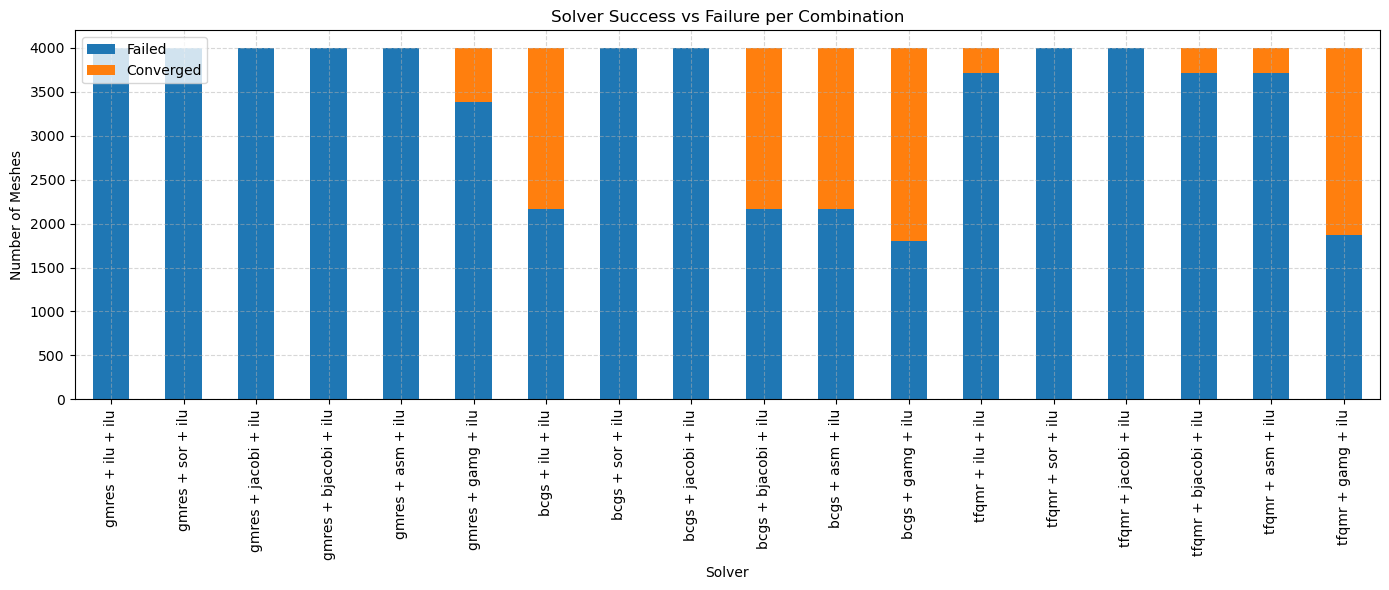

In [4]:
# Plot
summary.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.xlabel("Solver Combination")
plt.ylabel("Number of Meshes")
plt.title("Solver Success vs Failure per Combination")
indices = np.arange(M)
plt.xticks(indices, df["Solver Label"][0:M], rotation=90)
plt.xlabel("Solver")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# For each mesh, build its 21-d convergence vector
pivot = df.pivot_table(
    index='Mesh #',
    columns='Combination #',
    values='Converged'
).sort_index()

# Convert to integers (0/1), then strings for hashing
vectors = pivot.astype(int).astype(str).agg(''.join, axis=1)

# Count unique convergence patterns
unique_patterns = vectors.nunique()
print(f"Unique convergence patterns: {unique_patterns} / {len(pivot)} total meshes")


Unique convergence patterns: 14 / 4000 total meshes


Unique convergence patterns: 14 / 4000 total meshes



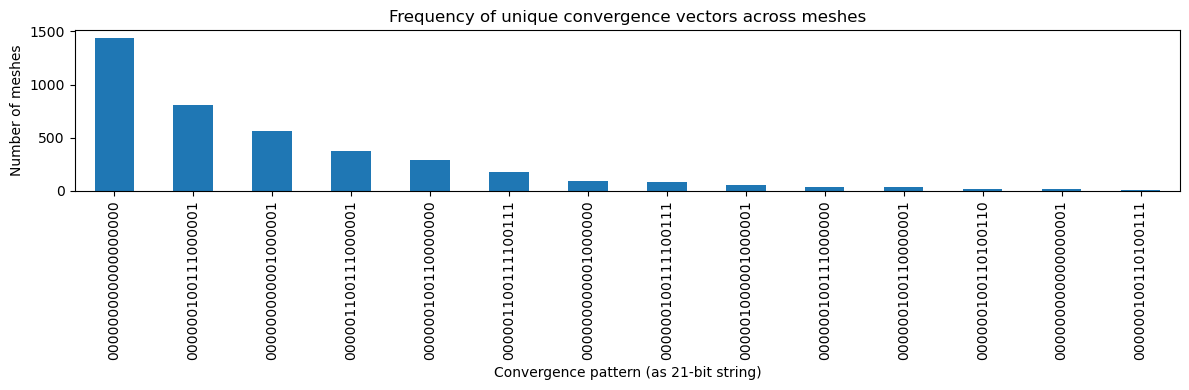

000000000000000000    1439
000000100111000001     812
000000000001000001     563
000001100111000001     376
000000100110000000     290
000001100111100111     182
000000000001000000      93
000000100111100111      83
000001000001000001      55
000000100111000000      35
000000100110000001      33
000000100110100110      19
000000000000000001      15
000000100110100111       5
Name: count, dtype: int64


In [6]:

# Count how many times each unique pattern appears
pattern_counts = vectors.value_counts()

# Show summary
print(f"Unique convergence patterns: {len(pattern_counts)} / {len(pivot)} total meshes\n")



plt.figure(figsize=(12, 4))
pattern_counts.plot(kind='bar')
plt.ylabel("Number of meshes")
plt.xlabel("Convergence pattern (as 21-bit string)")
plt.title("Frequency of unique convergence vectors across meshes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


print(pattern_counts)

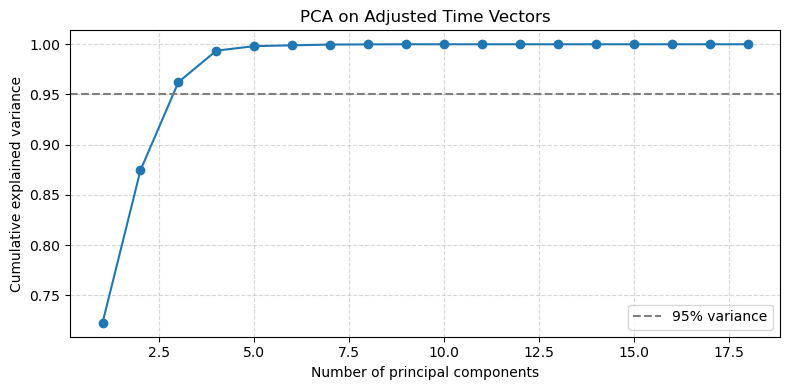

In [7]:

# Pivot adjusted times: rows = mesh IDs, cols = solver combination #
adjusted_pivot = df.pivot_table(
    index='Mesh #',
    columns='Combination #',
    values='Adjusted Time (s)'
).sort_index()

adjusted_log = adjusted_pivot.applymap(lambda x: -np.log(abs(x) + 1e-6))

# Run PCA
pca = PCA()
components = pca.fit_transform(adjusted_log)

# Explained variance
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
plt.axhline(0.95, color='gray', linestyle='--', label='95% variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA on Adjusted Time Vectors')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


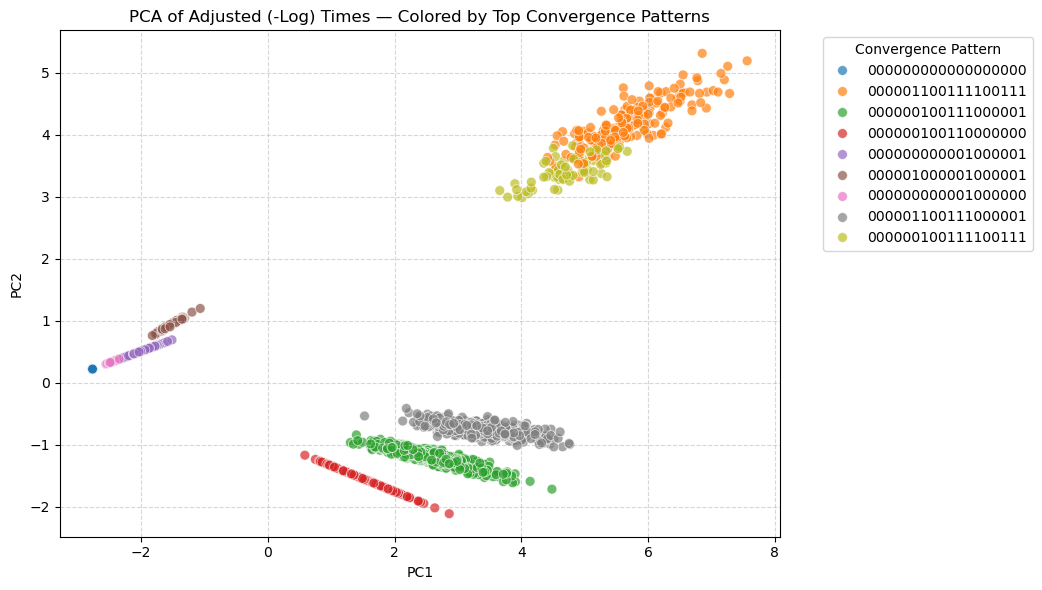

In [8]:

pca_df = pd.DataFrame(components[:, :2], columns=['PC1', 'PC2'])
pca_df['pattern'] = vectors.values

# Plot with color per pattern (most frequent first)
top_patterns = vectors.value_counts().index[:9]  # show only top 9 for clarity
filtered = pca_df[pca_df['pattern'].isin(top_patterns)]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=filtered,
    x='PC1', y='PC2',
    hue='pattern',
    palette='tab10',
    s=50,
    alpha=0.7
)
plt.title("PCA of Adjusted (-Log) Times — Colored by Top Convergence Patterns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title="Convergence Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


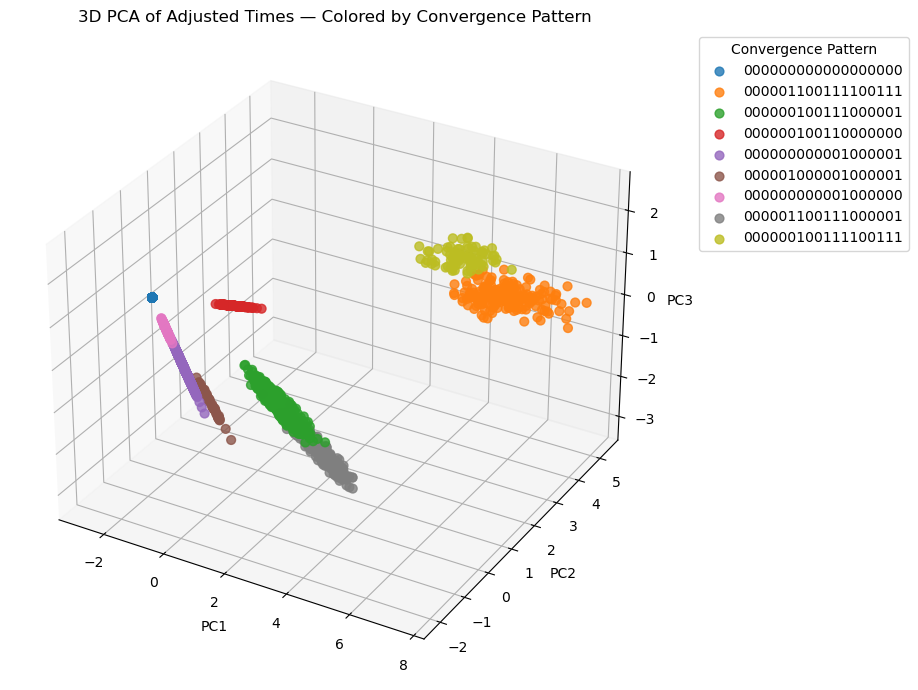

In [9]:
from mpl_toolkits.mplot3d import Axes3D  


pca_df = pd.DataFrame(components[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['pattern'] = vectors.values

# Filter top 11 patterns
top_patterns = vectors.value_counts().index[:9]
filtered = pca_df[pca_df['pattern'].isin(top_patterns)]

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign unique colors to each pattern
patterns = filtered['pattern'].unique()
colors = plt.cm.tab10.colors  # max 10, loop if needed

for i, pattern in enumerate(patterns):
    subset = filtered[filtered['pattern'] == pattern]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'],
        label=pattern,
        s=40,
        alpha=0.8,
        color=colors[i % len(colors)]
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of Adjusted Times — Colored by Convergence Pattern")
ax.legend(title="Convergence Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Feature creation script starts here

In [10]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import meshio

### Help Functions

In [11]:

def compute_edge_lengths(p0, p1, p2):
    a = np.linalg.norm(p1 - p0)
    b = np.linalg.norm(p2 - p1)
    c = np.linalg.norm(p0 - p2)
    return a, b, c

def compute_signed_area(p0, p1, p2):
    return 0.5 * ((p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1]))

def compute_rms_edge(a, b, c):
    return np.sqrt((a ** 2 + b ** 2 + c ** 2) / 3)

def compute_internal_angles(p0, p1, p2):
    def angle(a, b, c):
        ba = a - b
        bc = c - b
        cosa = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        return np.degrees(np.arccos(np.clip(cosa, -1, 1)))
    return angle(p1, p0, p2), angle(p0, p1, p2), angle(p0, p2, p1)

def compute_triangle_center(p0, p1, p2):
    return (p0 + p1 + p2) / 3

def compute_volume_length_metric(signed_area, rms_edge):
    return (4 * np.sqrt(3) / 3) * signed_area / (rms_edge ** 2) if rms_edge > 0 else 0

def compute_triangle_features(p0, p1, p2):
    a, b, c = compute_edge_lengths(p0, p1, p2)
    signed_area = compute_signed_area(p0, p1, p2)
    area = abs(signed_area)
    rms_edge = compute_rms_edge(a, b, c)
    vol_length = compute_volume_length_metric(signed_area, rms_edge)
    angles = compute_internal_angles(p0, p1, p2)
    center = compute_triangle_center(p0, p1, p2)

    return {
        "area": area,
        "signed_area": signed_area,
        "rms_edge": rms_edge,
        "volume_length_metric": vol_length,
        "min_angle": min(angles),
        "max_angle": max(angles),
        "center": center
    }




### Main Class to build the dataset

Loop over all meshes in the folder and create the DataFrame of features, add labeles and number of fractures from solve_times.csv

In [12]:
class MeshFeatureDatasetBuilder:
    def __init__(self, mesh_dir, solver_csv, output_csv, log_transform=True):
        self.mesh_dir = mesh_dir
        self.solver_df = pd.read_csv(solver_csv)
        self.output_csv = output_csv
        self.log_transform = log_transform

    def prepare_solver_tables(self):
        self.solver_times = self.solver_df.pivot_table(
            index='Mesh #', columns='Combination #', values='Adjusted Time (s)'
        ).sort_index()

        self.solver_convergence = self.solver_df.pivot_table(
            index='Mesh #', columns='Combination #', values='Converged'
        ).sort_index()

        self.fracture_counts = self.solver_df.groupby('Mesh #')['Fractures #'].first().to_dict()

    def summarize_array(self, arr, name):
        return {
            f"{name}_mean": np.mean(arr),
            f"{name}_median": np.median(arr),
            f"{name}_std": np.std(arr),
            f"{name}_5pct": np.percentile(arr, 5),
            f"{name}_95pct": np.percentile(arr, 95),
            f"{name}_min": np.min(arr),
            f"{name}_max": np.max(arr)
        }

    def compute_features_for_mesh(self, mesh_path, mesh_id):
        mesh = meshio.read(mesh_path)
        coords = mesh.points[:, :2]
        triangles = mesh.cells_dict.get("triangle")
        if triangles is None:
            raise ValueError(f"No triangles in {mesh_path}")

        areas, signed_areas, rms_edges, vol_lengths, min_angles, max_angles, centers = [], [], [], [], [], [], []
        for tri in triangles:
            pts = [coords[i] for i in tri]
            feats = compute_triangle_features(*pts)
            areas.append(feats["area"])
            signed_areas.append(feats["signed_area"])
            rms_edges.append(feats["rms_edge"])
            vol_lengths.append(feats["volume_length_metric"])
            min_angles.append(feats["min_angle"])
            max_angles.append(feats["max_angle"])
            centers.append(feats["center"])

        # Grading ratios
        tree = cKDTree(centers)
        grading_ratios = []
        for i, center in enumerate(centers):
            _, idxs = tree.query(center, k=2)
            h1, h2 = rms_edges[i], rms_edges[idxs[1]]
            grading_ratios.append(max(h1 / h2, h2 / h1))

        feature_dict = {
            "mesh_name": os.path.basename(mesh_path),
            "mesh_id": mesh_id,
            "n_elements": len(triangles),
            "n_nodes": len(coords),
            "n_fractures": self.fracture_counts.get(mesh_id, -1)
        }

        for arr, name in [
            (areas, "area"),
            (signed_areas, "signed_area"),
            (rms_edges, "rms_edge"),
            (vol_lengths, "volume_length_metric"),
            (min_angles, "min_angle"),
            (max_angles, "max_angle"),
            (grading_ratios, "grading_ratio")
        ]:
            feature_dict.update(self.summarize_array(arr, name))

        return feature_dict

    def extract_features_for_mesh(self, mesh_id):
        mesh_path = os.path.join(self.mesh_dir, f"mesh2d_Xfr_{mesh_id:04d}.msh")
        feature_dict = self.compute_features_for_mesh(mesh_path, mesh_id)

        y_time = self.solver_times.loc[mesh_id].values
        y_conv = self.solver_convergence.loc[mesh_id].values.astype(float)

        if self.log_transform:
            y_time = -np.log(np.abs(y_time) + 1e-6)

        for i, t in enumerate(y_time):
            feature_dict[f"y_time_{i}"] = t
        for i, c in enumerate(y_conv):
            feature_dict[f"y_conv_{i}"] = c

        return feature_dict

    def build_dataset(self):
        self.prepare_solver_tables()
        all_data = []
        for mesh_id in self.solver_times.index:
            try:
                feats = self.extract_features_for_mesh(mesh_id)
                all_data.append(feats)
                print(f"✅ Processed mesh {mesh_id}")
            except Exception as e:
                print(f"❌ Failed mesh {mesh_id}: {e}")

        df = pd.DataFrame(all_data)
        df.to_csv(self.output_csv, index=False)
        print(f"\n✅ Saved dataset to {self.output_csv}")


In [13]:
builder = MeshFeatureDatasetBuilder(
    mesh_dir="D:/ML4pmg/Data_Large23/",
    solver_csv="D:/ML4pmg/Data_Large23/solver_times.csv",
    output_csv="D:/ML4pmg/Data_Large23/mesh_features.csv",
    log_transform=True
)
builder.build_dataset()



✅ Processed mesh 0

✅ Processed mesh 1

✅ Processed mesh 2

✅ Processed mesh 3

✅ Processed mesh 4

✅ Processed mesh 5

✅ Processed mesh 6

✅ Processed mesh 7

✅ Processed mesh 8

✅ Processed mesh 9

✅ Processed mesh 10

✅ Processed mesh 11

✅ Processed mesh 12

✅ Processed mesh 13

✅ Processed mesh 14

✅ Processed mesh 15

✅ Processed mesh 16

✅ Processed mesh 17

✅ Processed mesh 18

✅ Processed mesh 19

✅ Processed mesh 20

✅ Processed mesh 21

✅ Processed mesh 22

✅ Processed mesh 23

✅ Processed mesh 24

✅ Processed mesh 25

✅ Processed mesh 26

✅ Processed mesh 27

✅ Processed mesh 28

✅ Processed mesh 29

✅ Processed mesh 30

✅ Processed mesh 31

✅ Processed mesh 32

✅ Processed mesh 33

✅ Processed mesh 34

✅ Processed mesh 35

✅ Processed mesh 36

✅ Processed mesh 37

✅ Processed mesh 38

✅ Processed mesh 39

✅ Processed mesh 40

✅ Processed mesh 41

✅ Processed mesh 42

✅ Processed mesh 43

✅ Processed mesh 44

✅ Processed mesh 45

✅ Processed mesh 46

✅ Processed mesh 47

✅

### Update with Convergence Patterns and Pattern IDs


In [14]:
def annotate_with_convergence_patterns(dataset_csv, output_csv):
    df = pd.read_csv(dataset_csv)

    # Extract convergence columns (assumed to start with 'y_conv_')
    y_conv_cols = [col for col in df.columns if col.startswith('y_conv_')]
    if not y_conv_cols:
        raise ValueError("No convergence columns (y_conv_*) found in dataset!")

    # Step 1 — Build convergence pattern string
    df['convergence_pattern'] = df[y_conv_cols].astype(int).astype(str).agg(''.join, axis=1)

    # Step 2 — Count frequencies of unique patterns
    pattern_counts = df['convergence_pattern'].value_counts()

    # Step 3 — Assign pattern_id by frequency (most common is 0)
    pattern_to_id = {pattern: idx for idx, pattern in enumerate(pattern_counts.index)}
    df['pattern_id'] = df['convergence_pattern'].map(pattern_to_id)

    # Step 4 — Save updated dataset
    df.to_csv(output_csv, index=False)
    print(f"✅ Annotated dataset saved to {output_csv}")
    print("\nTop patterns with counts:")
    print(pattern_counts.head(10))

    return df, pattern_counts


In [15]:
updated_df, pattern_counts = annotate_with_convergence_patterns(
    dataset_csv="D:/ML4pmg/Data_Large23/mesh_features.csv",
    output_csv="D:/ML4pmg/Data_Large23/mesh_features_annotated.csv"
)


✅ Annotated dataset saved to D:/ML4pmg/Data_Large23/mesh_features_annotated.csv

Top patterns with counts:
convergence_pattern
000000000000000000    1439
000000100111000001     812
000000000001000001     563
000001100111000001     376
000000100110000000     290
000001100111100111     182
000000000001000000      93
000000100111100111      83
000001000001000001      55
000000100111000000      35
Name: count, dtype: int64


### Make balanced dataset

In [17]:
def create_balanced_dataset_simple(df, top_k_patterns=5, samples_per_pattern=100, random_state=42, shuffle=True):
    balanced_parts = []

    for pattern_id in range(top_k_patterns):
        group = df[df['pattern_id'] == pattern_id]
        if len(group) >= samples_per_pattern:
            sampled = group.sample(n=samples_per_pattern, random_state=random_state)
        else:
            sampled = group.sample(n=samples_per_pattern, replace=True, random_state=random_state)
        balanced_parts.append(sampled)

    balanced_df = pd.concat(balanced_parts, ignore_index=True)

    if shuffle:
        balanced_df = balanced_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    print(f"✅ Balanced dataset with {samples_per_pattern} samples for each of {top_k_patterns} patterns.")

    return balanced_df


In [58]:
df = pd.read_csv("D:/ML4pmg/Data_Large23/mesh_features_annotated.csv")
balanced_df = create_balanced_dataset_simple(df, top_k_patterns=6, samples_per_pattern=250)
balanced_df.to_csv("D:/ML4pmg/Data_Large23/balanced_mesh_features.csv", index=False)


✅ Balanced dataset with 250 samples for each of 6 patterns.


### Stratified split of the dataset for training and test

In [59]:
from sklearn.model_selection import train_test_split

def stratified_train_test_split(df, test_size=0.2, random_state=42):
    train_parts = []
    test_parts = []

    for pattern_id, group in df.groupby('pattern_id'):
        train_group, test_group = train_test_split(
            group,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
        train_parts.append(train_group)
        test_parts.append(test_group)

    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df = pd.concat(test_parts).reset_index(drop=True)

    print(f"✅ Stratified split done. Train: {len(train_df)} samples, Test: {len(test_df)} samples.")
    return train_df, test_df


In [227]:
balanced_df = pd.read_csv("D:/ML4pmg/Data_Large23/balanced_mesh_features.csv")
train_df, test_df = stratified_train_test_split(balanced_df, test_size=0.2)


✅ Stratified split done. Train: 1200 samples, Test: 300 samples.


## Classification

In [228]:
# Prepare features and target
feature_cols = [col for col in train_df.columns if not col.startswith('y_') and col not in ['mesh_id', 'mesh_name', 'convergence_pattern', 'pattern_id']]
X_train = train_df[feature_cols].values
y_train = train_df['pattern_id'].values

X_test = test_df[feature_cols].values
y_test = test_df['pattern_id'].values

### Random Forest for Classification

In [230]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=24)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.66      0.68        50
           1       0.39      0.40      0.40        50
           2       0.62      0.60      0.61        50
           3       0.63      0.48      0.55        50
           4       0.47      0.48      0.48        50
           5       0.75      0.98      0.85        50

    accuracy                           0.60       300
   macro avg       0.60      0.60      0.59       300
weighted avg       0.60      0.60      0.59       300

Confusion Matrix:
 [[33  1  7  0  9  0]
 [ 2 20  5  8 14  1]
 [ 7 11 30  0  2  0]
 [ 0  7  2 24  2 15]
 [ 5 12  4  5 24  0]
 [ 0  0  0  1  0 49]]


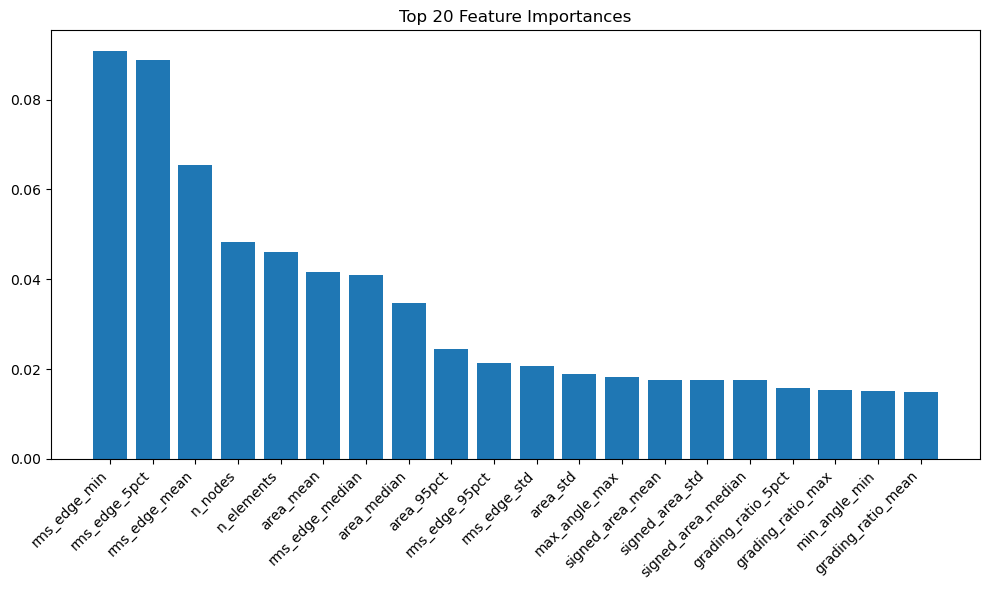

In [231]:


importances = clf.feature_importances_
feature_names = feature_cols  # as defined earlier

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [63]:
from scipy.stats import entropy

def compute_uncertainty_measures(y_proba):
    confidence = np.max(y_proba, axis=1)
    sorted_proba = np.sort(y_proba, axis=1)[:, ::-1]
    margin = sorted_proba[:, 0] - sorted_proba[:, 1]
    entropy_scores = entropy(y_proba.T,base =2) / np.log2(y_proba.shape[1])
        
    return confidence, margin, entropy_scores 


In [64]:
y_proba = clf.predict_proba(X_test)

confidence, margin, entropy = compute_uncertainty_measures(y_proba)

for i in range(5):
    print(f"Sample {i}: Confidence={confidence[i]:.2f}, Margin={margin[i]:.2f}, Entropy={entropy[i]:.2f}")


Sample 0: Confidence=0.37, Margin=0.03, Entropy=0.74
Sample 1: Confidence=0.72, Margin=0.52, Entropy=0.45
Sample 2: Confidence=0.68, Margin=0.39, Entropy=0.42
Sample 3: Confidence=0.71, Margin=0.45, Entropy=0.40
Sample 4: Confidence=0.54, Margin=0.16, Entropy=0.53


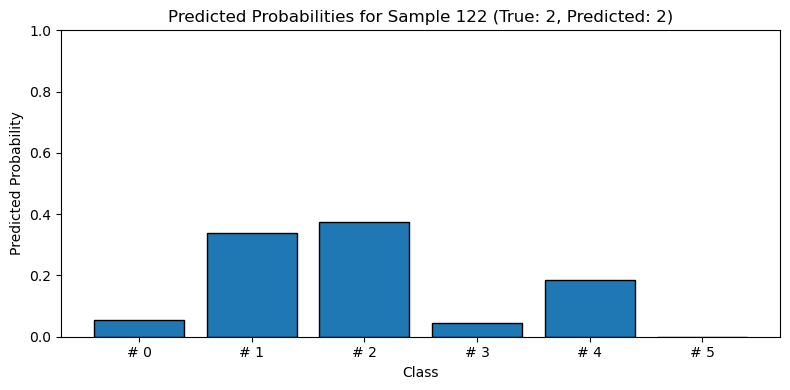

In [77]:
def plot_prediction_probabilities(y_proba_sample, class_labels=None, title="Prediction Probabilities"):
    plt.figure(figsize=(8, 4))
    classes = np.arange(len(y_proba_sample))
    plt.bar(classes, y_proba_sample, edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Predicted Probability")
    if class_labels is not None:
        plt.xticks(classes, class_labels)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Example usage:
sample_index = 122  # Choose which test sample to plot
plot_prediction_probabilities(
    y_proba[sample_index],
    class_labels=[f"# {i}" for i in range(y_proba.shape[1])],
    title=f"Predicted Probabilities for Sample {sample_index} (True: {y_test[sample_index]}, Predicted: {y_pred[sample_index]})"
)


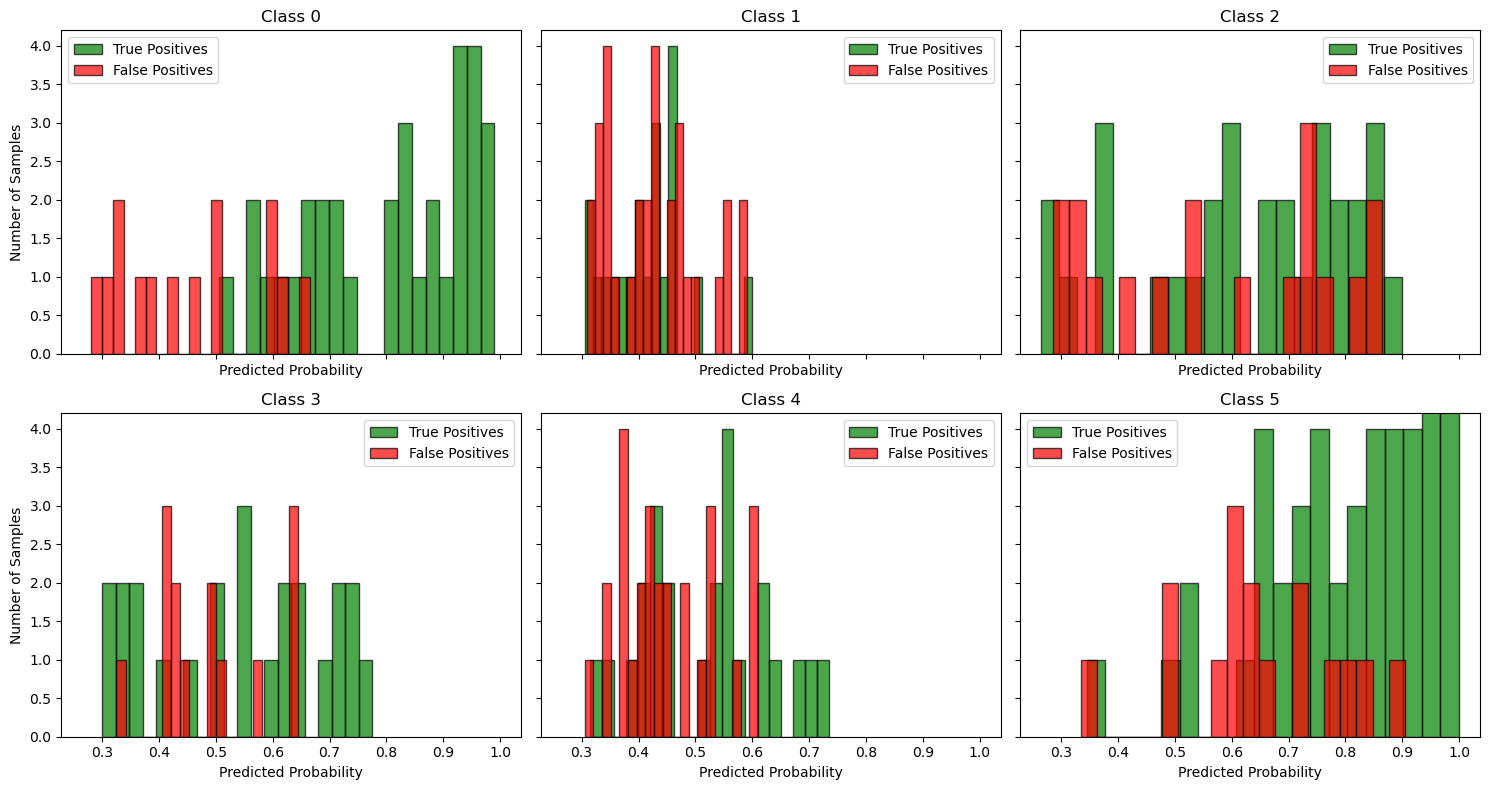

In [79]:

n_classes = y_proba.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_classes / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True, sharex=True)
axs = axs.flatten()

for class_idx in range(n_classes):
    ax = axs[class_idx]
    
    # True Positives: true == class_idx and predicted == class_idx
    tp_mask = (y_test == class_idx) & (y_pred == class_idx)
    
    # False Positives: true != class_idx and predicted == class_idx
    fp_mask = (y_test != class_idx) & (y_pred == class_idx)
    
    ax.hist(
        y_proba[tp_mask, class_idx], bins=20, color='green', alpha=0.7,
        label='True Positives', edgecolor='black'
    )
    ax.hist(
        y_proba[fp_mask, class_idx], bins=20, color='red', alpha=0.7,
        label='False Positives', edgecolor='black'
    )

    ax.set_title(f"Class {class_idx}")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylim(0, None)
    if class_idx % n_cols == 0:
        ax.set_ylabel("Number of Samples")
    ax.legend()

# Hide unused axes
for idx in range(n_classes, len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


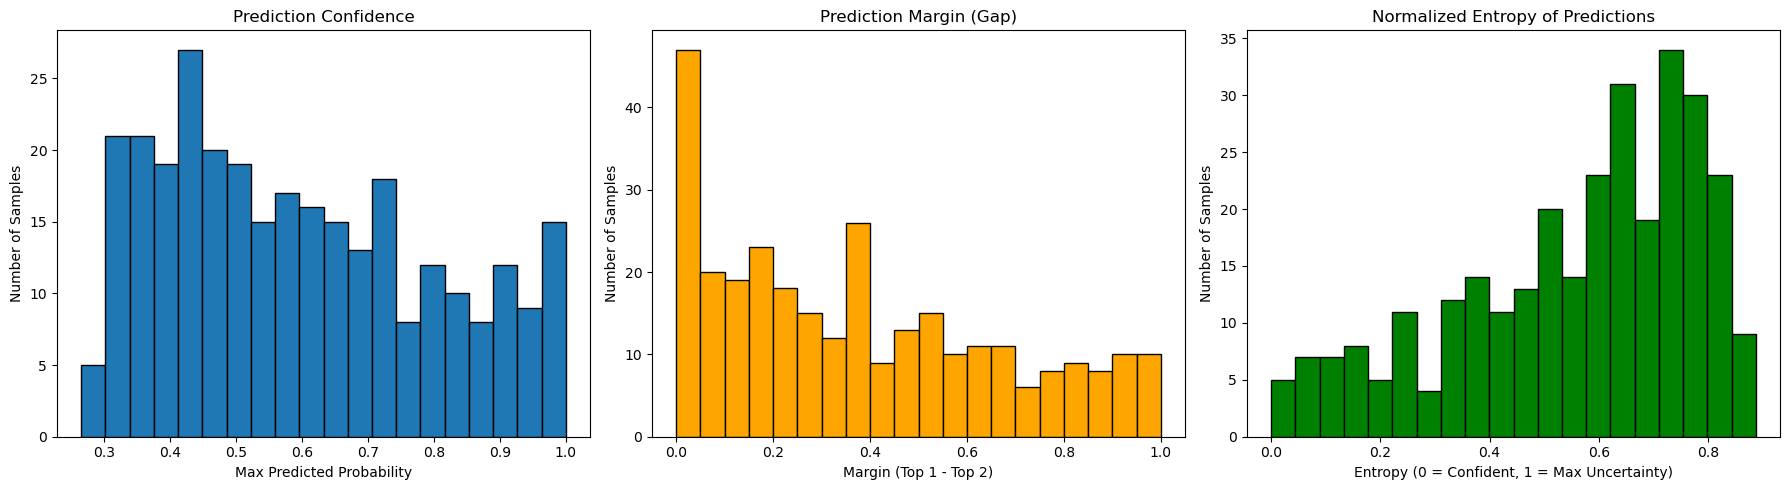

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Confidence histogram
axs[0].hist(confidence, bins=20, edgecolor='black')
axs[0].set_title("Prediction Confidence")
axs[0].set_xlabel("Max Predicted Probability")
axs[0].set_ylabel("Number of Samples")

# Margin histogram
axs[1].hist(margin, bins=20, edgecolor='black', color='orange')
axs[1].set_title("Prediction Margin (Gap)")
axs[1].set_xlabel("Margin (Top 1 - Top 2)")
axs[1].set_ylabel("Number of Samples")

# Normalized Entropy histogram
axs[2].hist(entropy, bins=20, edgecolor='black', color='green')
axs[2].set_title("Normalized Entropy of Predictions")
axs[2].set_xlabel("Entropy (0 = Confident, 1 = Max Uncertainty)")
axs[2].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()



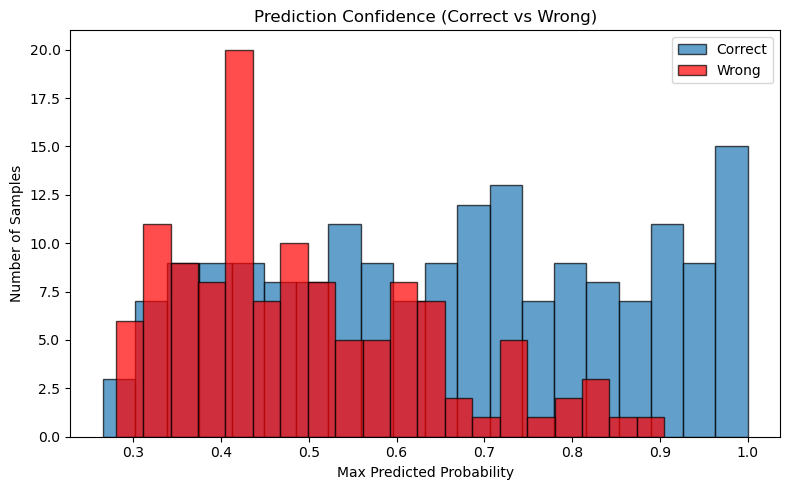

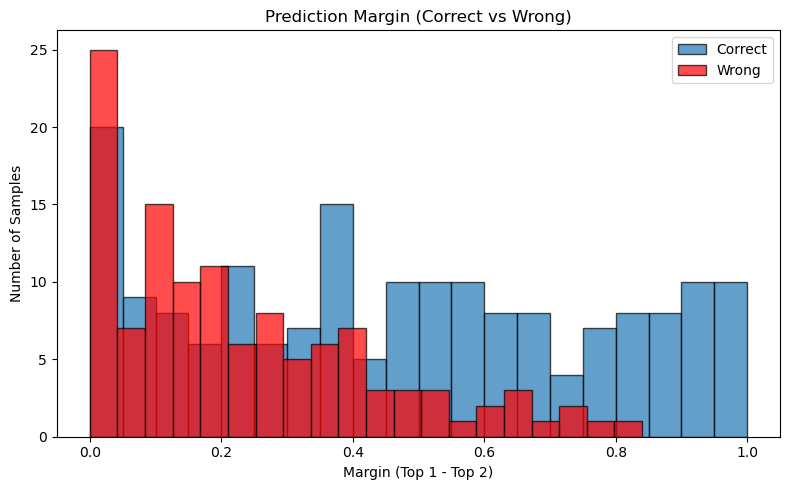

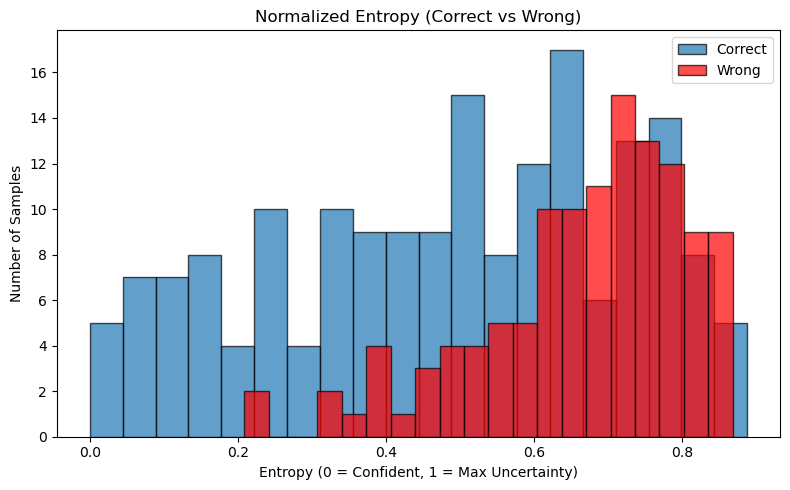

In [67]:

# Assuming you have:
# y_test — true labels
# y_pred — predicted labels
# confidence, margin, normalized_entropy — computed uncertainty measures

# Create masks
correct_mask = y_test == y_pred
wrong_mask = ~correct_mask

# Plotting function
def plot_histograms_split(metric, correct_vals, wrong_vals, title, xlabel):
    plt.figure(figsize=(8, 5))
    plt.hist(correct_vals, bins=20, alpha=0.7, label="Correct", edgecolor='black')
    plt.hist(wrong_vals, bins=20, alpha=0.7, label="Wrong", edgecolor='black', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Samples")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for Confidence
plot_histograms_split(
    confidence, 
    confidence[correct_mask], 
    confidence[wrong_mask], 
    "Prediction Confidence (Correct vs Wrong)", 
    "Max Predicted Probability"
)

# Plot for Margin
plot_histograms_split(
    margin, 
    margin[correct_mask], 
    margin[wrong_mask], 
    "Prediction Margin (Correct vs Wrong)", 
    "Margin (Top 1 - Top 2)"
)

# Plot for Normalized Entropy
plot_histograms_split(
    entropy, 
    entropy[correct_mask], 
    entropy[wrong_mask], 
    "Normalized Entropy (Correct vs Wrong)", 
    "Entropy (0 = Confident, 1 = Max Uncertainty)"
)


In [232]:
y_pred_class = y_pred

### Exploring Feature Importance

#### Impurity Importance

In [1]:

def plot_impurity_importance(clf, feature_names, top_n=30):
    importances = clf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
    plt.xlabel("Impurity-Based Importance")
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

    return importance_df


In [2]:
# Already trained classifier (clf), and feature_cols = list of feature names
importance_df = plot_impurity_importance(clf, feature_cols)


NameError: name 'clf' is not defined

### Gradient Boosting Trees

In [81]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72        50
           1       0.45      0.42      0.43        50
           2       0.66      0.76      0.70        50
           3       0.57      0.50      0.53        50
           4       0.48      0.44      0.46        50
           5       0.77      0.92      0.84        50

    accuracy                           0.62       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.61      0.62      0.61       300

Confusion Matrix:
 [[34  2  8  0  6  0]
 [ 3 21  6  6 13  1]
 [ 2  5 38  2  3  0]
 [ 0  8  2 25  2 13]
 [ 6 11  4  7 22  0]
 [ 0  0  0  4  0 46]]


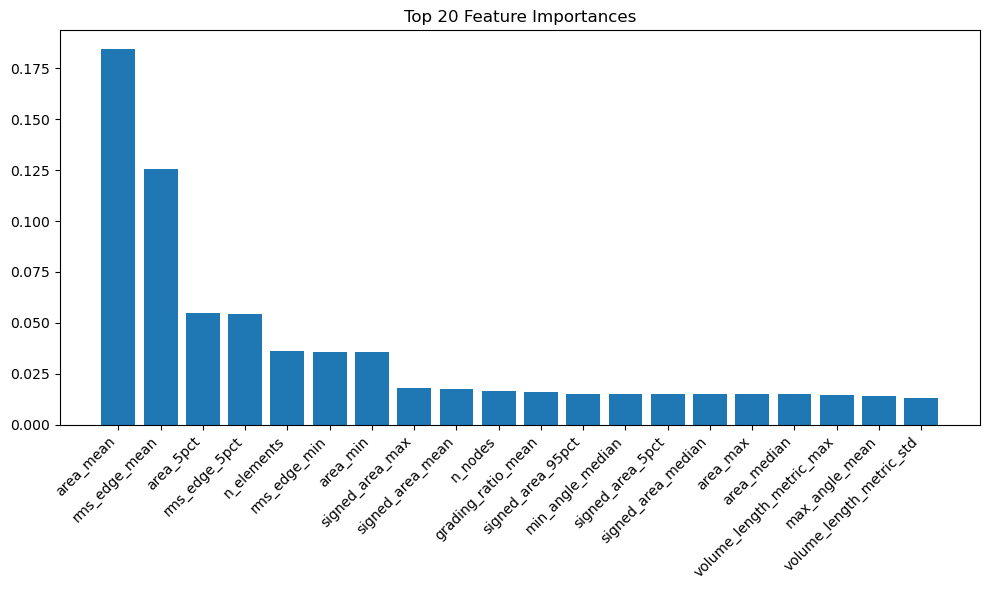

In [55]:
importances = clf.feature_importances_
feature_names = feature_cols  # as defined earlier

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

#### With scaling, not too important for Random Forest and GB Trees, but for Logistic Regression! 

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.62      0.64        40
           1       0.35      0.20      0.25        40
           2       0.56      0.70      0.62        40
           3       0.61      0.62      0.62        40
           4       0.47      0.50      0.48        40
           5       0.69      0.78      0.73        40

    accuracy                           0.57       240
   macro avg       0.55      0.57      0.56       240
weighted avg       0.55      0.57      0.56       240

Confusion Matrix:
 [[25  1  9  0  5  0]
 [ 1  8 10  3 14  4]
 [10  0 28  2  0  0]
 [ 0  2  1 25  2 10]
 [ 2 12  2  4 20  0]
 [ 0  0  0  7  2 31]]


## Regression

- /mesh_features_annotated.csv for full dataset
- /balanced_mesh_features_annotated.csv for the balanced (with converence patterns) dataset 

In [234]:
#df = pd.read_csv("D:/ML4pmg/Data_Large23/mesh_features_annotated.csv")
df = pd.read_csv("D:/ML4pmg/Data_Large23/balanced_mesh_features.csv",  dtype={'convergence_pattern': str}) # Or balanced!

In [235]:
df['convergence_pattern']

0        100110000000
1       1100111100111
2        100111000001
3        100111000001
4        100111000001
            ...      
1495     100110000000
1496    1100111100111
1497    1100111000001
1498    1100111100111
1499     100110000000
Name: convergence_pattern, Length: 1500, dtype: object

In [236]:
expected_length = 18

# Pad with zeros on the left if needed
df['convergence_pattern'] = df['convergence_pattern'].apply(
    lambda x: str(x).zfill(expected_length)
)

# ✅ Check that they are correct now
print(df['convergence_pattern'].head().tolist())


['000000100110000000', '000001100111100111', '000000100111000001', '000000100111000001', '000000100111000001']


In [237]:
df['convergence_pattern']

0       000000100110000000
1       000001100111100111
2       000000100111000001
3       000000100111000001
4       000000100111000001
               ...        
1495    000000100110000000
1496    000001100111100111
1497    000001100111000001
1498    000001100111100111
1499    000000100110000000
Name: convergence_pattern, Length: 1500, dtype: object

### Remove columns with constact times (as some solvers never converge)

In [238]:

# Select all y_time_* columns
y_time_cols = [col for col in df.columns if col.startswith('y_time_')]


# Find the global minimum (the default value for diverged solver)
global_max_time = df[y_time_cols].min().min()

print(f"✅ Global max solver time: {global_max_time:.4f}")


# Identify non-constant targets (with variance > 0)
non_constant_y_time_cols = [
    col for col in y_time_cols if df[col].nunique() > 1
]

print("✅ Keeping targets:", non_constant_y_time_cols)
print("❌ Dropping targets:", set(y_time_cols) - set(non_constant_y_time_cols))

# Optionally, drop constant columns
filtered_df = df.drop(columns=list(set(y_time_cols) - set(non_constant_y_time_cols)))


✅ Global max solver time: -1.4403
✅ Keeping targets: ['y_time_5', 'y_time_6', 'y_time_9', 'y_time_10', 'y_time_11', 'y_time_12', 'y_time_15', 'y_time_16', 'y_time_17']
❌ Dropping targets: {'y_time_3', 'y_time_1', 'y_time_0', 'y_time_7', 'y_time_8', 'y_time_4', 'y_time_2', 'y_time_13', 'y_time_14'}


In [239]:

# Get the indices of kept targets (assuming y_time_0, y_time_1, ...)
# Extract the integer suffix
kept_indices = sorted([
    int(col.replace('y_time_', ''))
    for col in non_constant_y_time_cols
])

print("✅ Kept solver indices:", kept_indices)

# Prepare the pattern id → reduced convergence pattern mapping
pattern_df = filtered_df[['pattern_id', 'convergence_pattern']].drop_duplicates().sort_values('pattern_id')
pattern_id_to_array = {
    row['pattern_id']: np.array([int(str(row['convergence_pattern'])[idx]) for idx in kept_indices])
    for _, row in pattern_df.iterrows()
}


print("✅ Pattern mapping with reduced dimention")
for pid in range(6):
    print(f"Pattern {pid}: {pattern_id_to_array[pid]}")


✅ Kept solver indices: [5, 6, 9, 10, 11, 12, 15, 16, 17]
✅ Pattern mapping with reduced dimention
Pattern 0: [0 0 0 0 0 0 0 0 0]
Pattern 1: [0 1 1 1 1 0 0 0 1]
Pattern 2: [0 0 0 0 1 0 0 0 1]
Pattern 3: [1 1 1 1 1 0 0 0 1]
Pattern 4: [0 1 1 1 0 0 0 0 0]
Pattern 5: [1 1 1 1 1 1 1 1 1]


In [240]:

# train_df, test_df = train_test_split(
#     filtered_df,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True
# )

# print(f"✅ Random split done. Train: {len(train_df)} samples, Test: {len(test_df)} samples.")

# Or for balanced dataset
train_df, test_df = stratified_train_test_split(filtered_df, test_size=0.2)

✅ Stratified split done. Train: 1200 samples, Test: 300 samples.


In [241]:
# Select feature columns (exclude y_*, mesh_id, etc.)
feature_cols = [
    col for col in train_df.columns 
    if not col.startswith('y_') and col not in ['mesh_id', 'mesh_name', 'convergence_pattern', 'pattern_id']
]

# Select target columns (y_time_0 to y_time_17)
target_cols = [col for col in train_df.columns if col.startswith('y_time_')]

# Prepare training and test sets
X_train = train_df[feature_cols].values
y_train = train_df[target_cols].values # already log transformed!

X_test = test_df[feature_cols].values
y_test = test_df[target_cols].values


## Random Forest Regressor

In [243]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize RandomForestRegressor
regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)


# Fit to training data
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate performance per target
for i, target_name in enumerate(target_cols):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, R² = {r2:.4f}")


y_time_5: MSE = 0.2840, R² = 0.7800
y_time_6: MSE = 0.6418, R² = 0.7014
y_time_9: MSE = 0.6533, R² = 0.6988
y_time_10: MSE = 0.6103, R² = 0.7020
y_time_11: MSE = 0.3997, R² = 0.6513
y_time_12: MSE = 0.4389, R² = 0.6951
y_time_15: MSE = 0.4412, R² = 0.6991
y_time_16: MSE = 0.4151, R² = 0.6963
y_time_17: MSE = 0.3848, R² = 0.6501


In [246]:
y_test.shape

(300, 9)

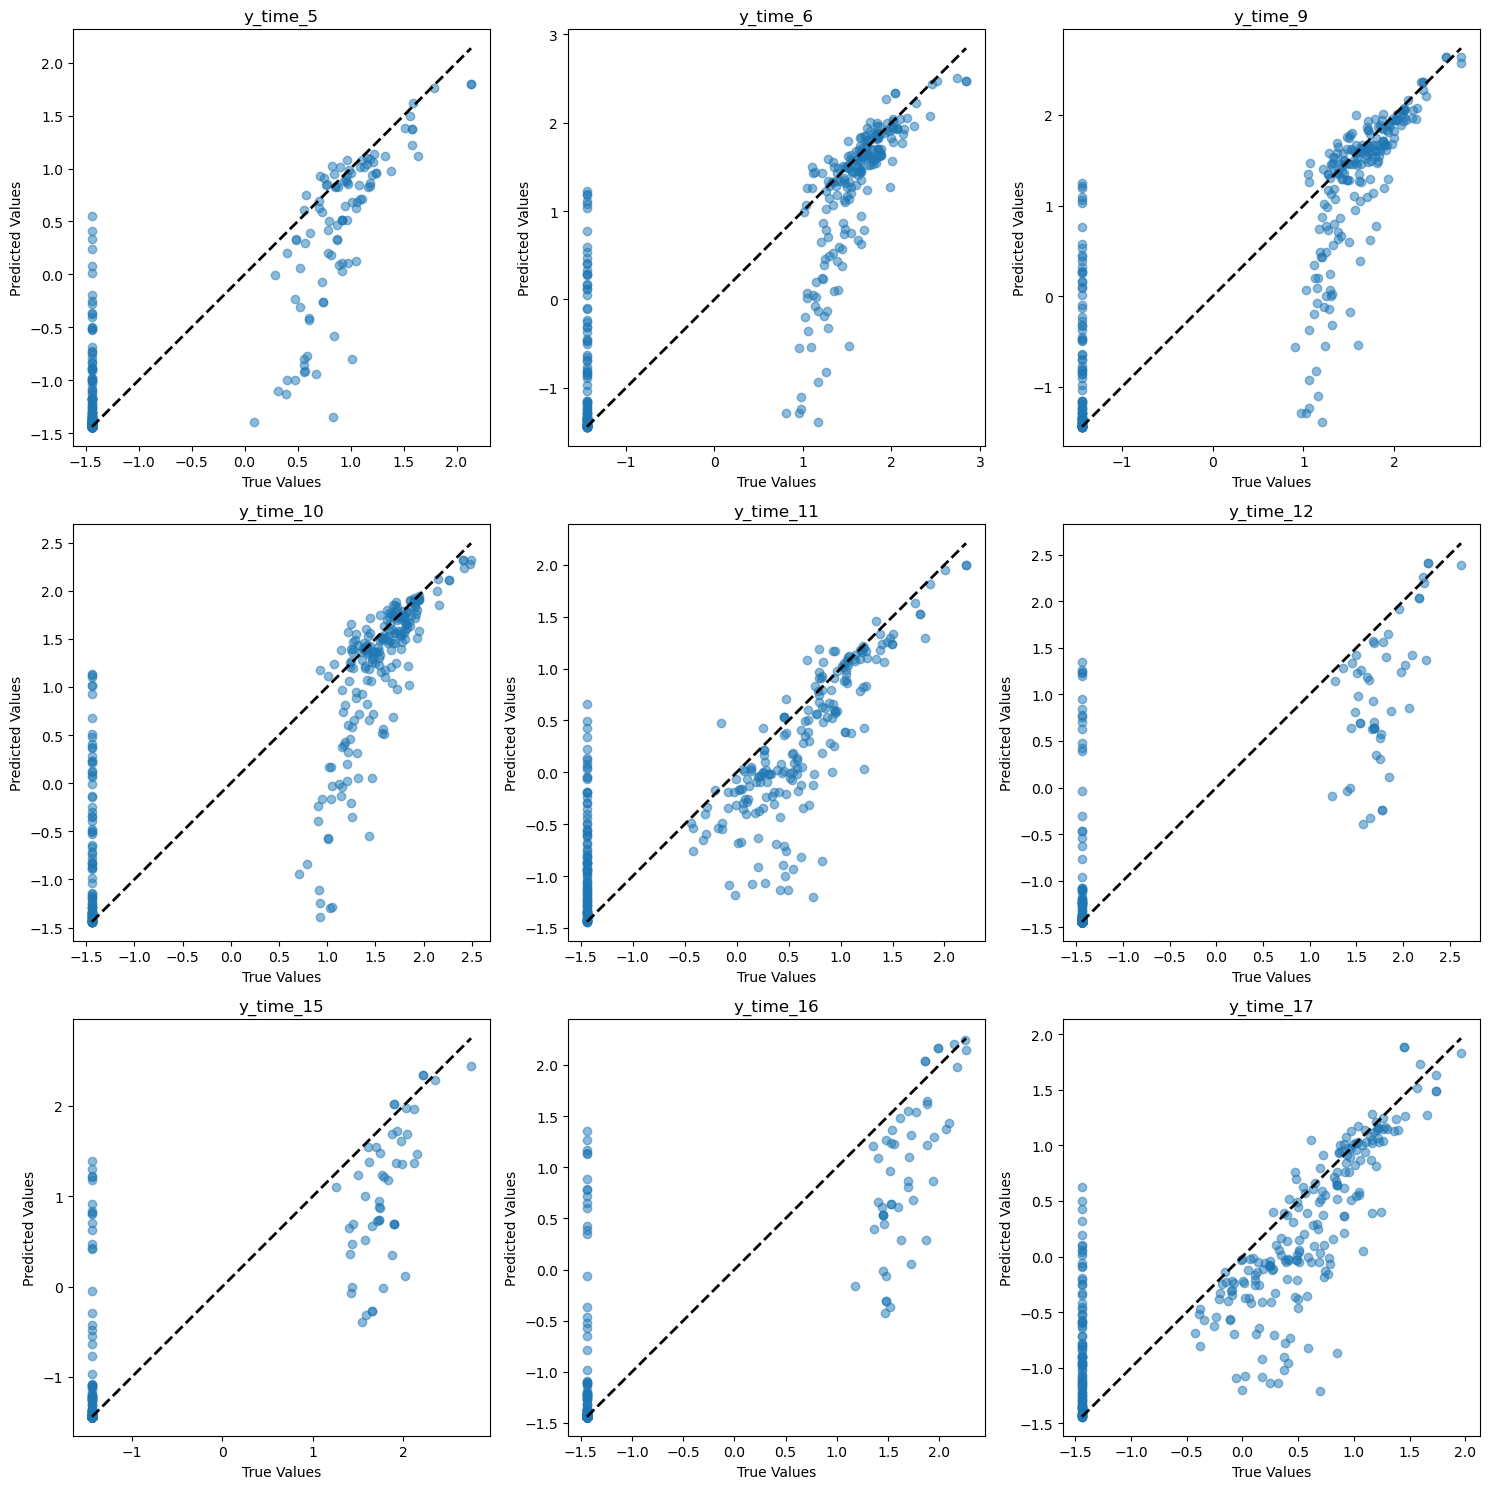

In [248]:
n_targets = len(target_cols)
n_cols = 3
n_rows = int(np.ceil(n_targets / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axs = axs.flatten()

for i, target_name in enumerate(target_cols):
    ax = axs[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_title(f"{target_name}")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")

# Hide unused subplots if any
for j in range(n_targets, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

plt.show()


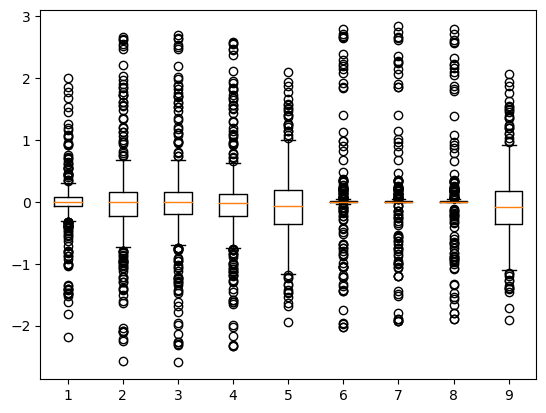

In [265]:
err= y_pred - y_test
plt.boxplot(err)
plt.show()

In [254]:
def adjusted_pred(y_pred, y_pred_class, pattern_id_to_array, T_default):
    """
    Adjusts the regression predictions based on predicted convergence pattern.

    Parameters:
    - y_pred: (n_samples, n_targets) numpy array of regression outputs.
    - y_pred_class: (n_samples,) numpy array of predicted pattern_id (from classifier).
    - pattern_id_to_array: dict {pattern_id: np.array of 0/1} mapping convergence pattern.
    - T_default: default value to assign to non-converged solvers.

    Returns:
    - y_pred_adj: (n_samples, n_targets) numpy array of adjusted predictions.
    """
    y_pred_adj = []

    for i in range(len(y_pred)):
        pattern_id = y_pred_class[i]
        mask = pattern_id_to_array[pattern_id]
        masked_row = np.where(mask == 1, y_pred[i], T_default)
        y_pred_adj.append(masked_row)

    return np.array(y_pred_adj)


In [255]:
y_pred_adjusted = adjusted_pred(y_pred, y_pred_class, pattern_id_to_array, T_default=global_max_time)


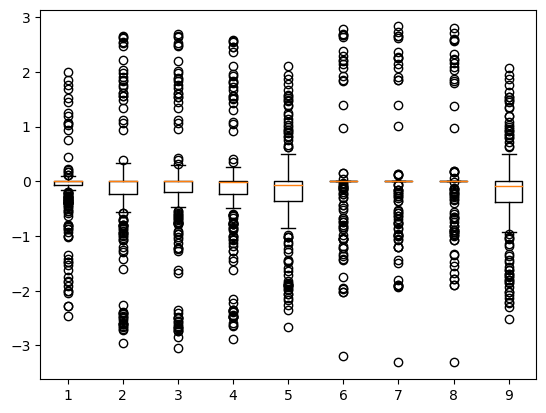

In [264]:
err= y_pred_adjusted - y_test
plt.boxplot(err)
plt.show()

In [267]:
global_max_time

-1.4402661837350523

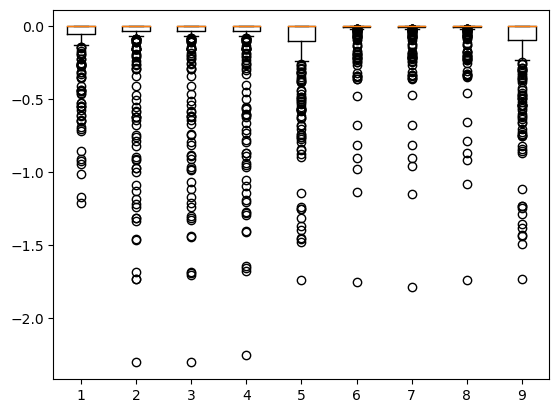

In [266]:
err= y_pred_adjusted - y_pred
plt.boxplot(err)
plt.show()

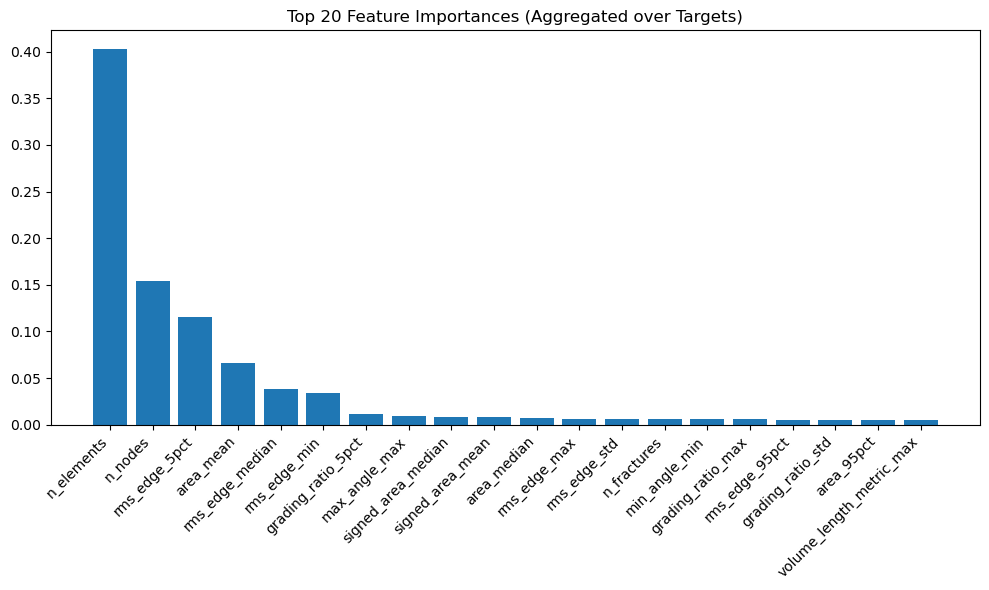

In [155]:

importances = regressor.feature_importances_
feature_names = feature_cols

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances (Aggregated over Targets)")
plt.tight_layout()
plt.show()


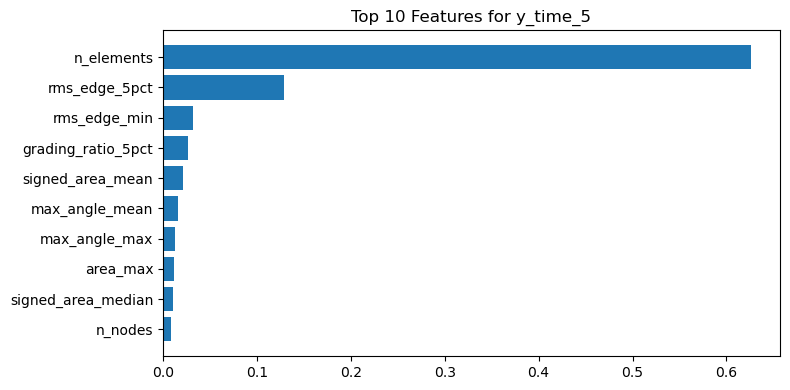

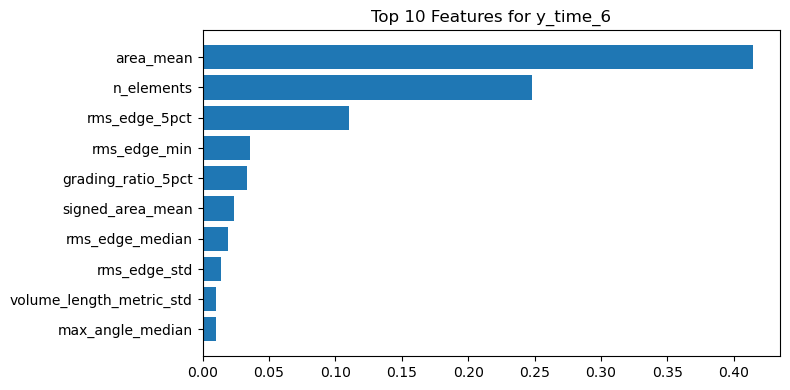

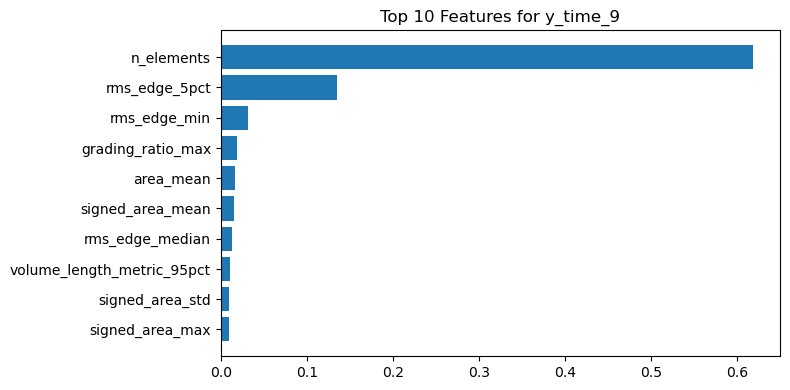

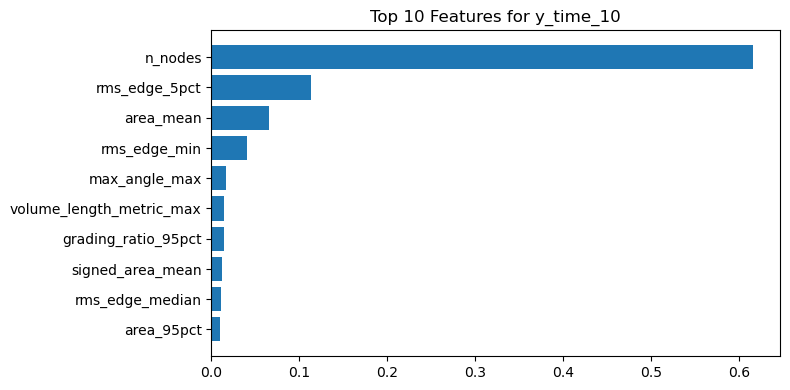

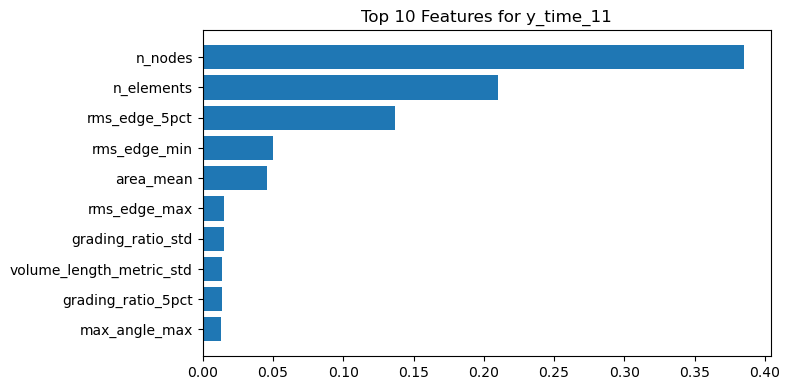

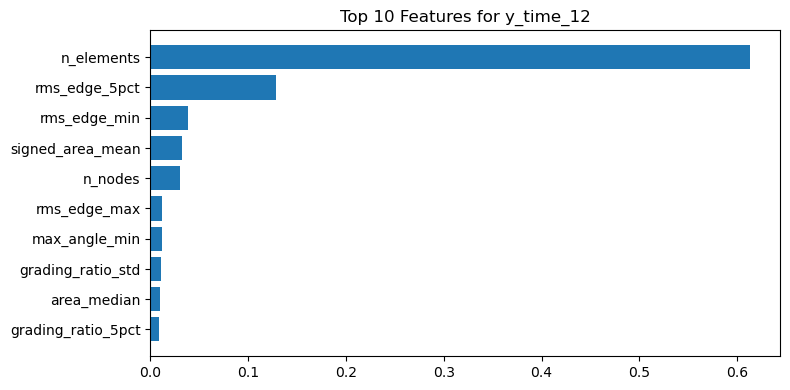

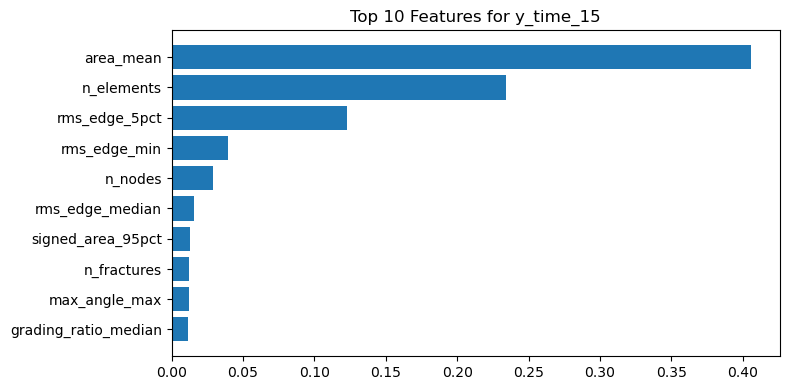

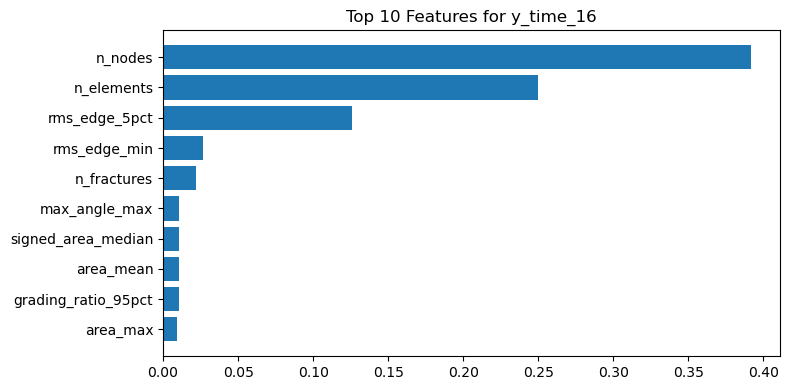

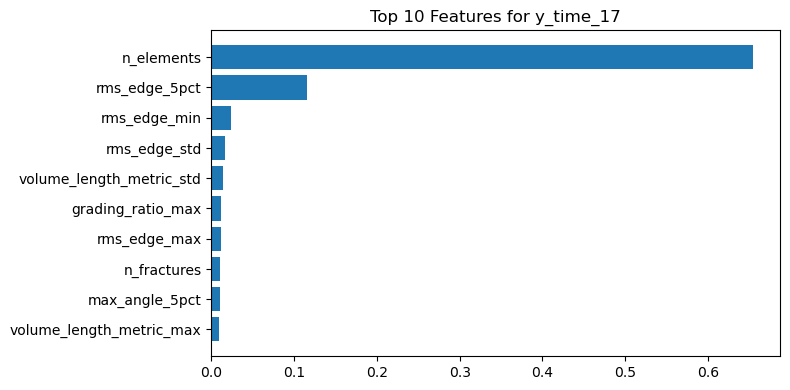

In [156]:

importances_df = pd.DataFrame()

for i, target_name in enumerate(target_cols):
    importances = regressor.estimators_[i].feature_importances_
    df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'target': target_name
    })
    importances_df = pd.concat([importances_df, df], ignore_index=True)

for target_name in target_cols:
    target_importances = (
        importances_df[importances_df['target'] == target_name]
        .sort_values('importance', ascending=False)
        .head(10)
    )
    plt.figure(figsize=(8, 4))
    plt.barh(target_importances['feature'], target_importances['importance'])
    plt.title(f"Top 10 Features for {target_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



## Gradient Boosing Trees

In [160]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define base regressor
gbr_base = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Wrap with MultiOutputRegressor
gbr = MultiOutputRegressor(gbr_base)

# Fit model
gbr.fit(X_train, y_train)

# Predict
y_pred = gbr.predict(X_test)

# Evaluate
for i, target_name in enumerate(target_cols):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, R² = {r2:.4f}")


y_time_5: MSE = 0.2585, R² = 0.7997
y_time_6: MSE = 0.6483, R² = 0.6985
y_time_9: MSE = 0.6736, R² = 0.6894
y_time_10: MSE = 0.6239, R² = 0.6953
y_time_11: MSE = 0.4043, R² = 0.6473
y_time_12: MSE = 0.4048, R² = 0.7188
y_time_15: MSE = 0.3780, R² = 0.7421
y_time_16: MSE = 0.3758, R² = 0.7250
y_time_17: MSE = 0.4047, R² = 0.6320


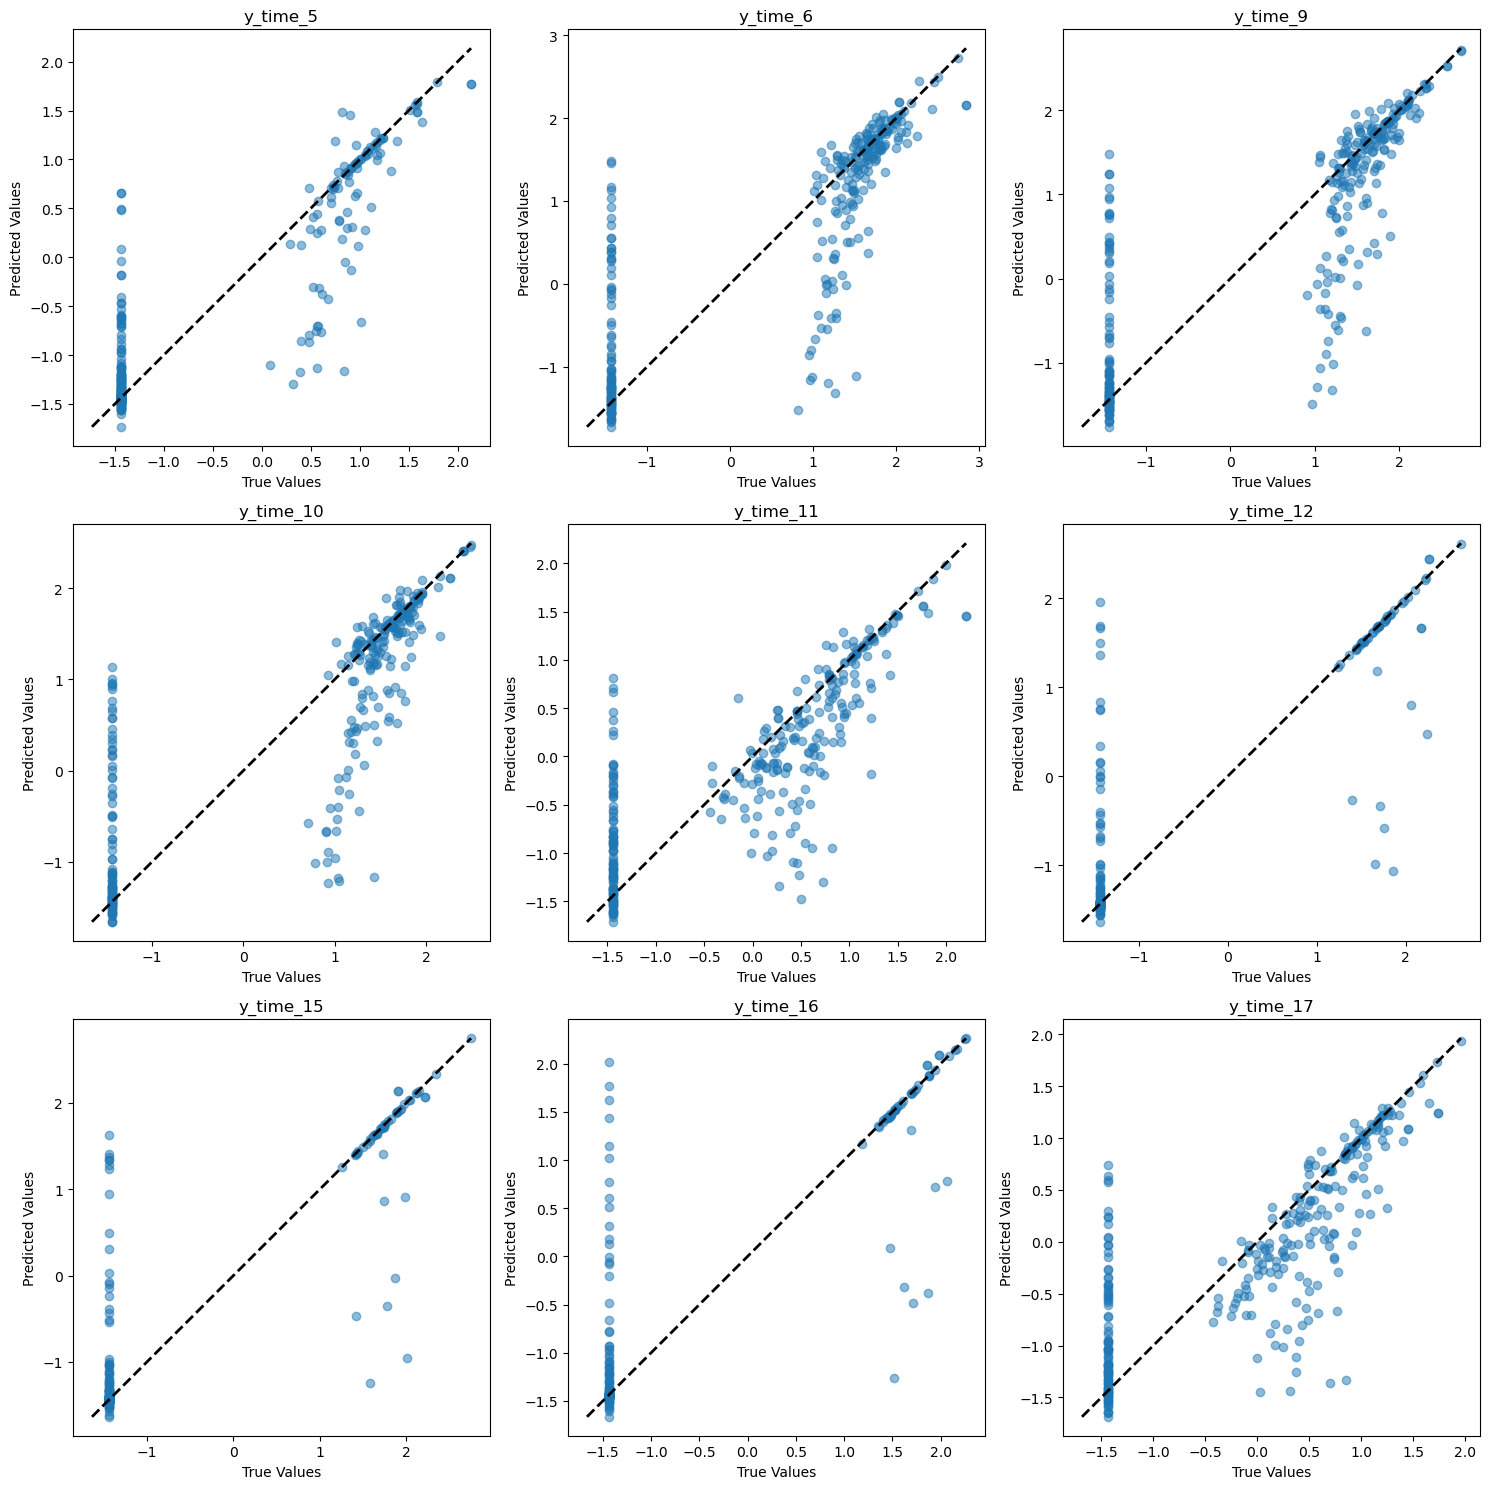

In [164]:
n_targets = len(target_cols)
n_cols = 3
n_rows = int(np.ceil(n_targets / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axs = axs.flatten()

for i, target_name in enumerate(target_cols):
    ax = axs[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_title(f"{target_name}")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")

# Hide unused subplots if any
for j in range(n_targets, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

plt.show()

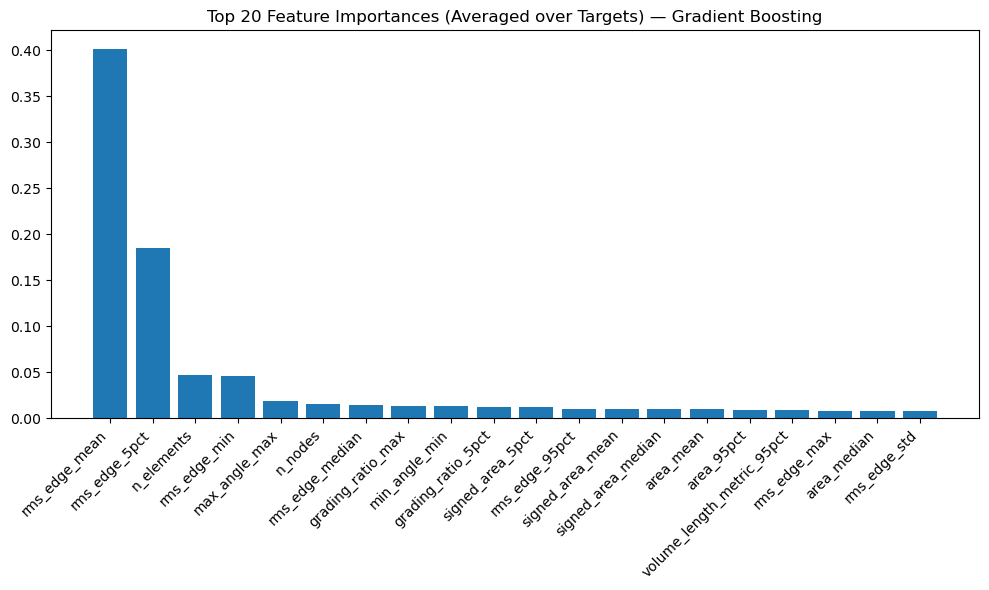

In [161]:

# Collect importances from each estimator
all_importances = []

for i, est in enumerate(gbr.estimators_):  # gbr is your MultiOutputRegressor
    importances = est.feature_importances_
    all_importances.append(importances)

# Convert to array and compute mean importance per feature
all_importances = np.array(all_importances)
mean_importances = all_importances.mean(axis=0)

# Sort and plot top 20
sorted_idx = np.argsort(mean_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), mean_importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_cols[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances (Averaged over Targets) — Gradient Boosting")
plt.tight_layout()
plt.show()


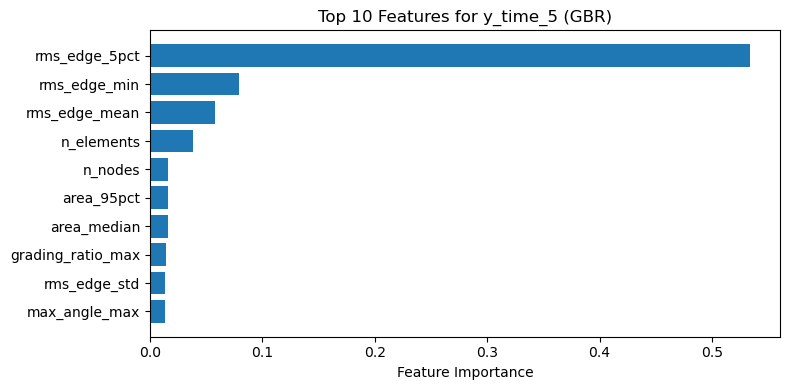

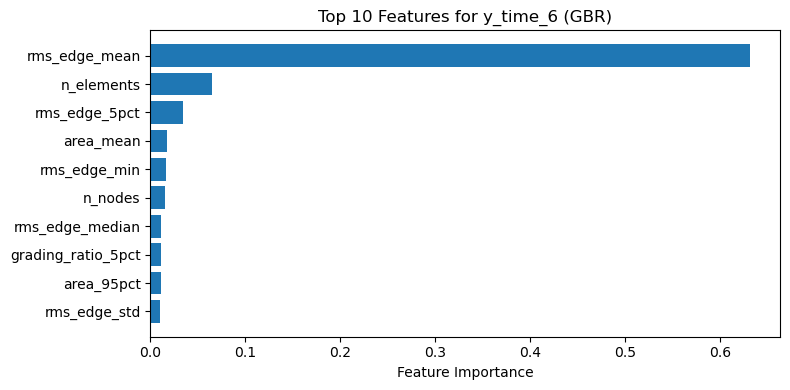

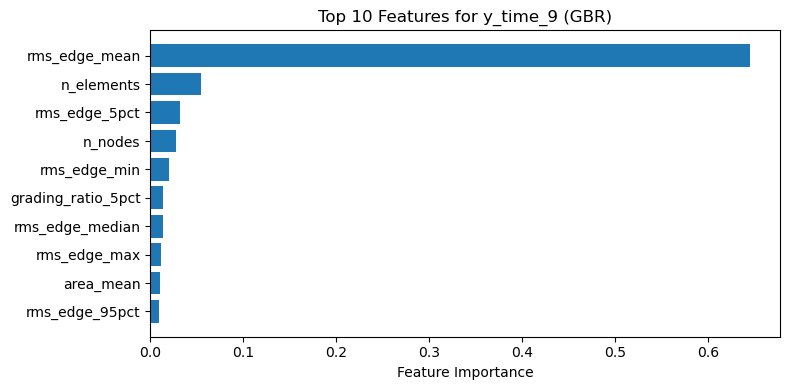

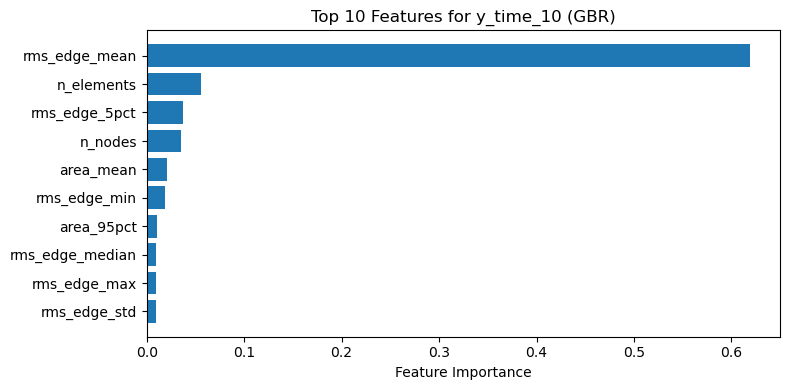

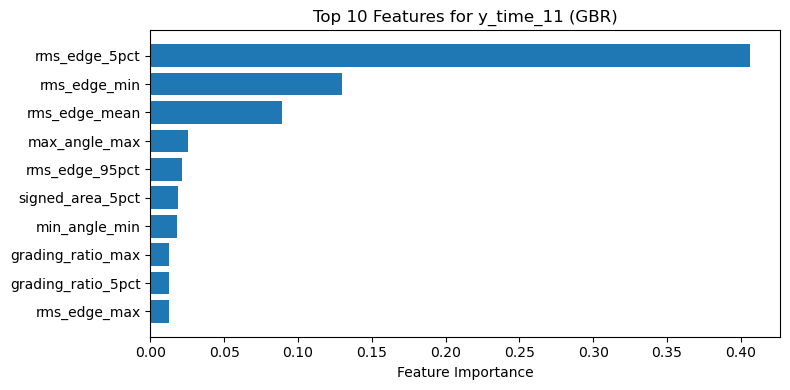

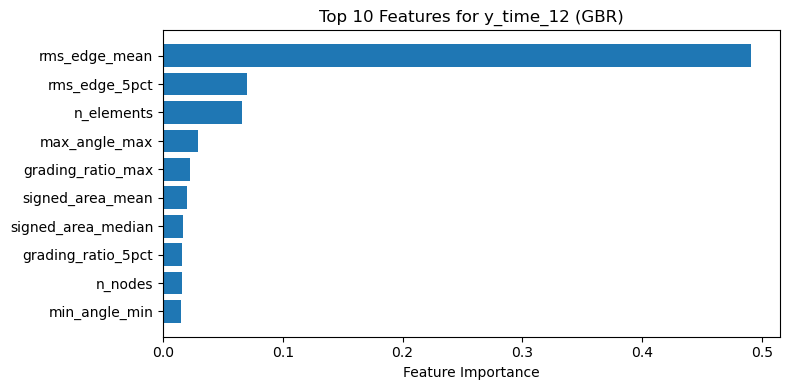

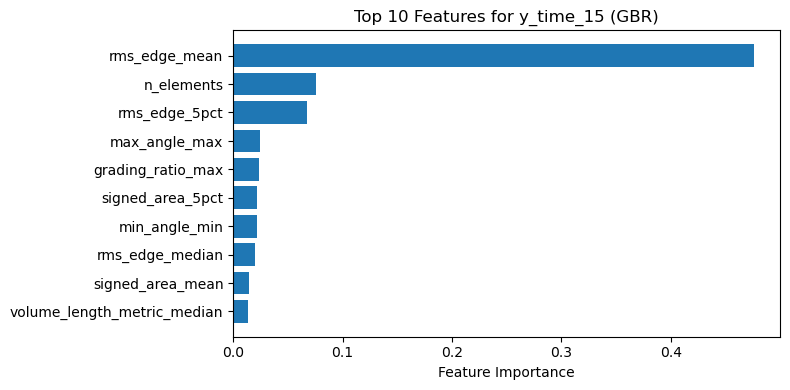

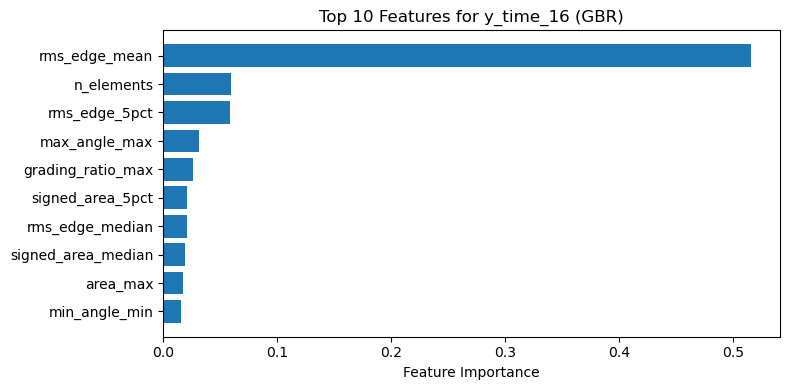

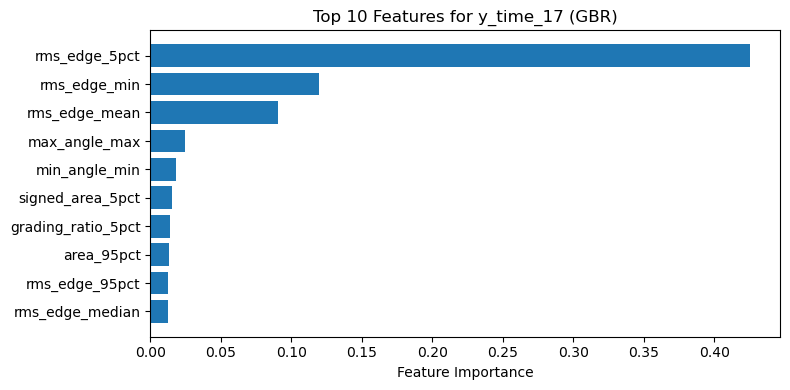

In [163]:

# Collect importances per target
importances_df = pd.DataFrame()

for i, est in enumerate(gbr.estimators_):
    importances = est.feature_importances_
    df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'target': target_cols[i]
    })
    importances_df = pd.concat([importances_df, df], ignore_index=True)

# Plot per target
for target_name in target_cols:
    target_importances = (
        importances_df[importances_df['target'] == target_name]
        .sort_values('importance', ascending=False)
        .head(10)
    )
    
    plt.figure(figsize=(8, 4))
    plt.barh(target_importances['feature'], target_importances['importance'])
    plt.title(f"Top 10 Features for {target_name} (GBR)")
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
